In [ ]:
import pandas as pd

# plot
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import random
import numpy as np

import math

In [2]:
import time 
start_time  = int(time.time())
import pandas as pd 
import numpy as np
from keras.layers import *
from keras.models import Sequential
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import random as rn
import tensorflow as tf
from keras import backend as K

def SetTheSeed(Seed):
    np.random.seed(Seed)
    rn.seed(Seed)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)

    tf.set_random_seed(Seed)

    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

Using TensorFlow backend.


In [3]:
# def functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
# read data
train = pd.read_csv('ProjectTrainingData.csv')

# 1 1000000 Sample

## 1.1 All

In [7]:
# # take 1000000 samples
sample = train.sample(1000000, random_state = 613)

print(sample.click.value_counts())
print(len(sample[sample.click == 1])/len(sample)) # 17%

# sample.to_csv('sample.csv', index = False)

0    829194
1    170806
Name: click, dtype: int64
0.170806


In [ ]:
# get date of sample
sample['date'] = round((sample.hour - 14100000)/100).astype('int')

# get hour of sample
sample.hour = sample.hour - 14100000 - sample.date * 100

for i in range(2, 25):
        sample.iloc[:, i] = sample.iloc[:, i].astype('category') # change to categorical variables
sample = sample.iloc[:, 1:] # delete id

In [12]:
sample.drop(['device_id', 'device_ip'], axis = 1, inplace = True) # so many categories, drop these two variables for now

In [13]:
for cat_var in sample.columns:
    print (cat_var, sample[cat_var].nunique())

click 2
hour 24
C1 7
banner_pos 7
site_id 2647
site_domain 2888
site_category 23
app_id 3184
app_domain 194
app_category 26
device_model 5156
device_type 4
device_conn_type 4
C14 2114
C15 8
C16 9
C17 396
C18 4
C19 65
C20 162
C21 55
date 9


In [14]:
X = sample.iloc[:,1:]
X.columns

Index(['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_model', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'date'],
      dtype='object')

In [15]:
from sklearn.model_selection import train_test_split

# Split validation
X_train, X_test, y_train, y_test = train_test_split(
    sample.iloc[:, 1:], sample['click'], test_size = 0.4, random_state = 613, stratify = sample['click'])

# Ordinal Encoding
from sklearn import preprocessing
X_train_ordinal = X_train.values
X_test_ordinal = X_test.values
les = []

for i in range(X_train_ordinal.shape[1]):
    le = preprocessing.LabelEncoder()
    le.fit(sample.iloc[:,1:].iloc[:, i])
    les.append(le)
    X_train_ordinal[:, i] = le.transform(X_train_ordinal[:, i])
    X_test_ordinal[:, i] = le.transform(X_test_ordinal[:, i])
    
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_ordinal)
X_train_one_hot = enc.transform(X_train_ordinal)
X_test_one_hot = enc.transform(X_test_ordinal)

In [16]:
X_train_one_hot

<600000x15209 sparse matrix of type '<class 'numpy.float64'>'
	with 12600000 stored elements in Compressed Sparse Row format>

In [89]:
# Feature Scaling

In [ ]:
# Build the model
SetTheSeed(1234)

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

#Initializing Neural Network
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, input_shape = (X_train_one_hot.shape[1],), activation = 'relu', use_bias = True))
# Adding the second hidden layer
classifier.add(Dense(units = 6, activation = 'relu', use_bias = True))
# Adding the output layer
classifier.add(Dense(units = 1, activation = 'sigmoid', use_bias = True))

classifier.compile(optimizer = optimizers.RMSprop(lr=0.01), loss = 'binary_crossentropy', metrics = ['accuracy']) # optimizer can change


In [48]:
# Fitting our model 
classifier.fit(X_train_one_hot, y_train, batch_size = 500, nb_epoch = 2) # no more epoch

C:\Users\jczsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/2
600000/600000 [==============================] - 106s 176us/step - loss: 0.4088 - acc: 0.8312
Epoch 2/2
600000/600000 [==============================] - 100s 166us/step - loss: 0.4035 - acc: 0.8330


In [49]:
y_pred = classifier.predict(X_test_one_hot)

In [50]:
# y_pred = classifier.predict(X_test_one_hot)
from sklearn.metrics import log_loss
log_loss(y_test, y_pred)

0.40398547970797166

Confusion matrix, without normalization
[[327401   4277]
 [ 62185   6137]]
Normalized confusion matrix
[[0.99 0.01]
 [0.91 0.09]]


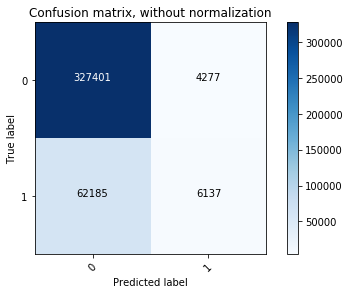

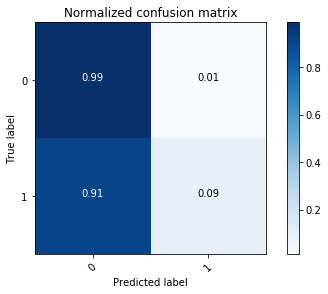

Accuracy (out-of-sample): 0.83
F1 score (out-of-sample):  0.5318707329843335
Kappa score (out-of-sample):  0.11594374105824001
Classification report:                precision    recall  f1-score   support

           0       0.84      0.99      0.91    331678
           1       0.59      0.09      0.16     68322

   micro avg       0.83      0.83      0.83    400000
   macro avg       0.71      0.54      0.53    400000
weighted avg       0.80      0.83      0.78    400000

AUC:  0.5384648085462576


In [51]:
y_pred = (y_pred > 0.5)
import itertools
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report
from sklearn.metrics import log_loss
    
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, y_pred))

# F1 score
print('F1 score (out-of-sample): ', f1_score(y_test, y_pred, average='macro'))

# Kappa score
print('Kappa score (out-of-sample): ', cohen_kappa_score(y_test, y_pred))

# Build a text report showing the main classification metrics (out-of-sample performance)
print('Classification report: ',classification_report(y_test, y_pred, target_names=['0', '1']))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUC: ', roc_auc)